In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import dask
dask.config.set(scheduler='threads')

In [5]:
# Remote Zarr Data Linking (CHIRPS Complete)
store_url = "https://nyu1.osn.mghpcc.org/leap-pangeo-pipeline/chirps_feedstock/chirps-global-daily.zarr"
# Load Zarr Data
ds = xr.open_dataset(store_url, engine="zarr", consolidated=True)

# Automatically determine latitude order and crop Ghana region (4°N-11°N, -3°-2°E)
lat_min, lat_max = 4.5, 11.5
if ds.latitude[0] < ds.latitude[-1]:
    lat_slice = slice(lat_min, lat_max)
else:
    lat_slice = slice(lat_max, lat_min)

ghana_ds = ds.sel(
    latitude=lat_slice,
    longitude=slice(-4, 2),
    time=slice("2000-01-01", "2020-12-31")
)

# Save as NetCDF file
ghana_ds.to_netcdf("ghana_chirps_2000_2020.nc")

ds = xr.open_dataset("ghana_chirps_2000_2020.nc")
precip = ds['precip']

print(precip)

precip = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6])).compute()

print(precip.shape) 

<xarray.DataArray 'precip' (time: 7671, latitude: 140, longitude: 120)> Size: 515MB
[128872800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 560B 4.525 4.575 4.625 ... 11.37 11.42 11.47
  * longitude  (longitude) float32 480B -3.975 -3.925 -3.875 ... 1.925 1.975
  * time       (time) datetime64[ns] 61kB 2000-01-01 2000-01-02 ... 2020-12-31
Attributes:
    geostatial_lat_max:  50.0
    geostatial_lat_min:  -50.0
    geostatial_lon_max:  180.0
    geostatial_lon_min:  -180.0
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    standard_name:       convective precipitation rate
    time_step:           day
    units:               mm/day
(2562, 140, 120)


In [6]:
ds_2020 = ds.sel(time=slice("2020-01-01", "2020-12-31"))
total_precip = ds_2020['precip'].sum(dim='time')

In [7]:
# Figure 1 #

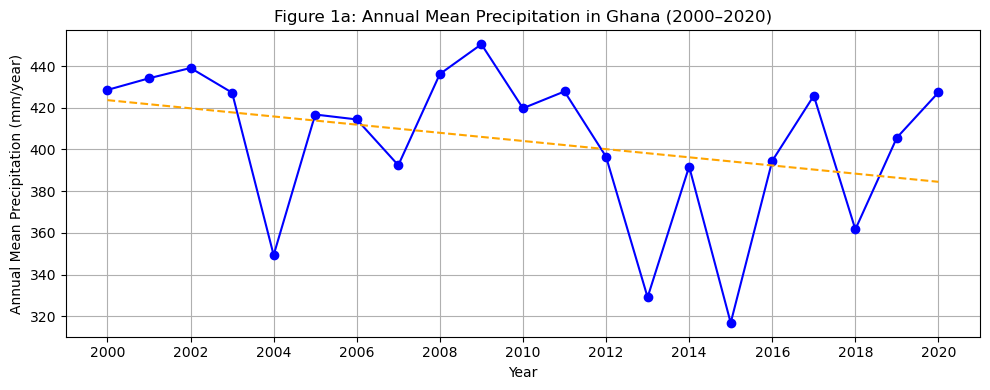

In [9]:
annual_precip = precip.groupby('time.year').sum(dim='time')

annual_mean_precip = annual_precip.mean(dim=['latitude', 'longitude'])

years = annual_mean_precip.year.values
values = annual_mean_precip.values

slope, intercept = np.polyfit(years, values, 1)
trend = slope * years + intercept

plt.figure(figsize=(10, 4))
plt.plot(years, values, marker='o', linestyle='-', color='blue')
plt.plot(years, trend, linestyle='--', color='orange', label=f'Trend (slope = {slope:.2f} mm/year)')
plt.title("Figure 1a: Annual Mean Precipitation in Ghana (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Annual Mean Precipitation (mm/year)")
plt.xticks(np.arange(2000, 2021, 2))
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
years = np.arange(2000, 2021)

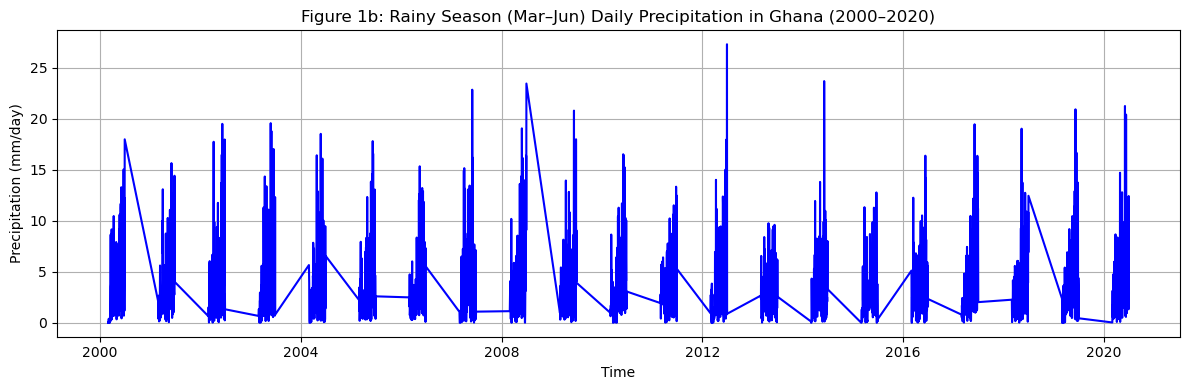

In [11]:
rainy_season = precip.where(precip['time'].dt.month.isin([3, 4, 5, 6]), drop=True)
precip['time'] = pd.to_datetime(precip['time'].values)

monthly_series = rainy_season.mean(dim=['latitude', 'longitude'])

plt.figure(figsize=(12, 4))
monthly_series.plot(color='blue')
plt.title("Figure 1b: Rainy Season (Mar–Jun) Daily Precipitation in Ghana (2000–2020)")
plt.xlabel("Time")
plt.ylabel("Precipitation (mm/day)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Figure 2 #

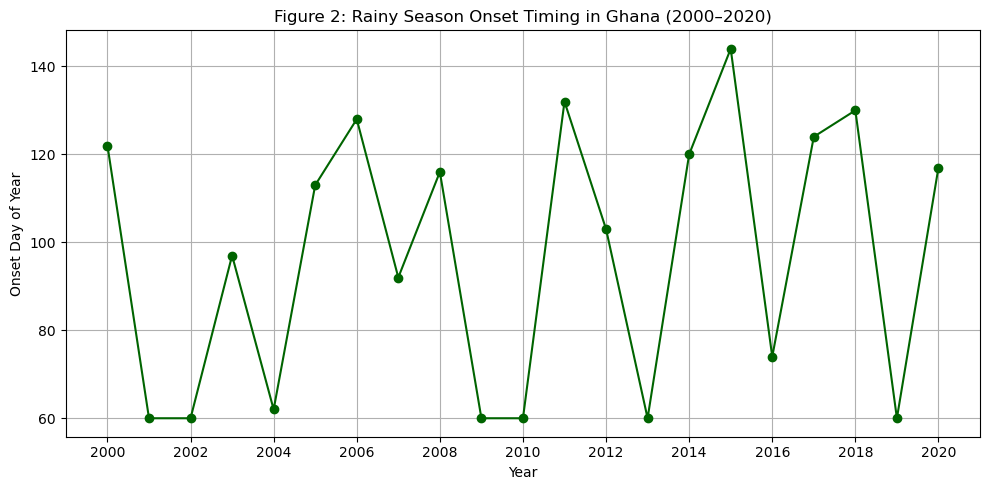

In [13]:
precip = ds['precip']

rainy_season = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

rolling = rainy_season.rolling(time=5).mean()

threshold = 5
onset_days = []

for year in years:
    season = rolling.sel(time=str(year))
    mean_over_space = season.mean(dim=['latitude', 'longitude'])
    
    condition = mean_over_space > threshold
    if condition.any():
        onset_day = condition.argmax(dim='time')
        onset_date = mean_over_space.time[onset_day]
        onset_days.append(onset_date.dt.dayofyear.values)
    else:
        onset_days.append(np.nan)

# Plot Onset Timing
plt.figure(figsize=(10, 5))
plt.plot(years, onset_days, marker='o', linestyle='-', color='darkgreen')
plt.title("Figure 2: Rainy Season Onset Timing in Ghana (2000–2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.xlabel("Year")
plt.ylabel("Onset Day of Year")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Figure 3 #

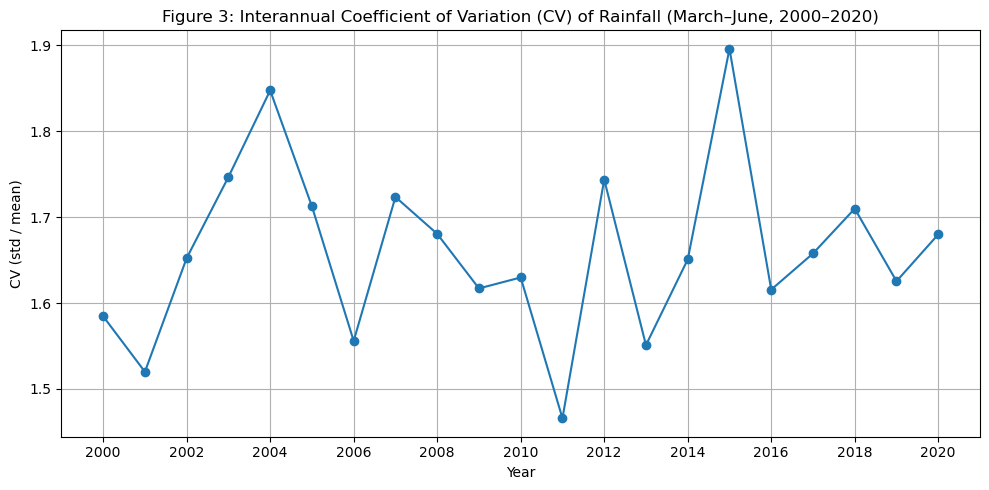

In [15]:
precip = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

# Group by year and compute mean and std over time and space
season_mean = precip.groupby('time.year').mean(dim=['time', 'latitude', 'longitude'])
season_std = precip.groupby('time.year').std(dim=['time', 'latitude', 'longitude'])

# Calculate Coefficient of Variation (CV)
cv = season_std / season_mean

# Plot CV time series
plt.figure(figsize=(10, 5))
cv.plot(marker='o')
plt.title("Figure 3: Interannual Coefficient of Variation (CV) of Rainfall (March–June, 2000–2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.xlabel("Year")
plt.ylabel("CV (std / mean)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
import geopandas as gpd
import rioxarray

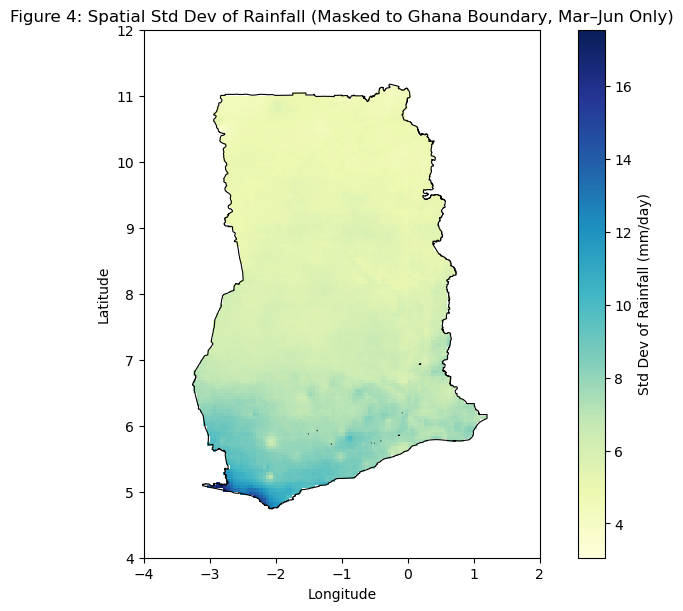

In [17]:
ghana_shape = gpd.read_file("gadm41_GHA_shp/gadm41_GHA_0.shp")  # Level 0

rainy_season = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

spatial_std = rainy_season.std(dim='time')

spatial_std.rio.write_crs("EPSG:4326", inplace=True)

masked_std = spatial_std.rio.clip(ghana_shape.geometry, ghana_shape.crs, drop=True)

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True) 
masked_std.plot(
    ax=ax,
    cmap="YlGnBu",
    cbar_kwargs={'label': 'Std Dev of Rainfall (mm/day)'}
)
ghana_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

ax.set_title("Figure 4: Spatial Std Dev of Rainfall (Masked to Ghana Boundary, Mar–Jun Only)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-4, 2)
ax.set_ylim(4, 12)
ax.set_aspect('equal')
plt.show()

In [18]:
print(ds.latitude.max().values)

11.474998


In [19]:
print(ds.longitude.min().values)

-3.975006


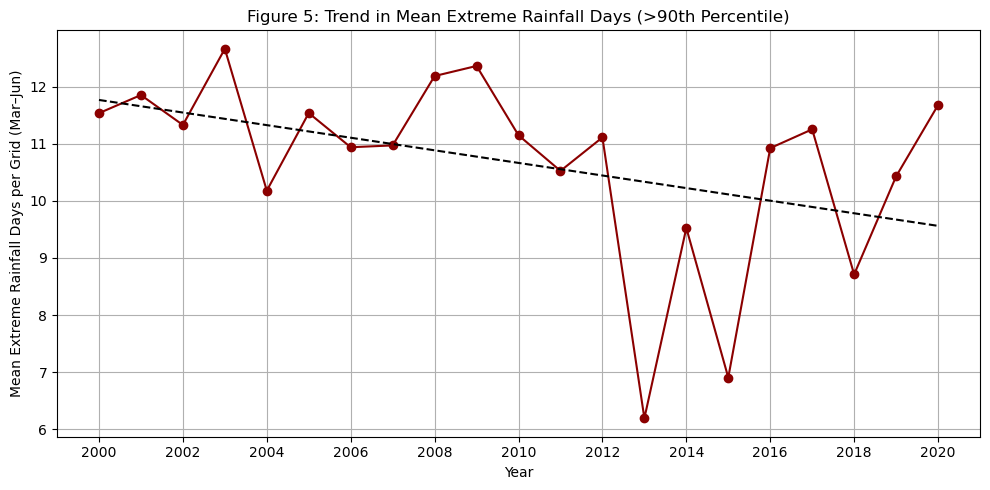

In [20]:
rainy_season = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

# Calculation of 90th percentile threshold (across time)
q90 = precip.quantile(0.9, dim='time')

# Create Boolean masks for extreme precipitation
threshold_mask = precip > q90

# How many extreme days per grid per year (summed across time)
extreme_days_per_year = threshold_mask.groupby('time.year').sum(dim='time')

# Average extreme days per grid (averaged across space)
mean_extreme_days = extreme_days_per_year.mean(dim=['latitude', 'longitude'])

years = mean_extreme_days.year.values
counts = mean_extreme_days.values

slope, intercept = np.polyfit(years, counts, 1)
trendline = slope * years + intercept

plt.figure(figsize=(10, 5))
plt.plot(years, counts, marker='o', linestyle='-', color='darkred')
plt.plot(years, trendline, linestyle='--', color='black', label=f'Trend Line (slope={slope:.2f})')
plt.title("Figure 5: Trend in Mean Extreme Rainfall Days (>90th Percentile)")

plt.xlabel("Year")
plt.ylabel("Mean Extreme Rainfall Days per Grid (Mar–Jun)")
plt.xticks(np.arange(2000, 2021, 2))
plt.grid(True)
plt.tight_layout()
plt.show()